In [1]:
import pandas as pd
import os
import glob
import time
import warnings
import statistics

from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, Plot, Grid, Range1d
from bokeh.models.glyphs import Text, Rect
from bokeh.layouts import gridplot
from bokeh.io import export_svg, output_notebook, install_notebook_hook, notebook
import numpy as np
import re
import seaborn as sb

from tqdm import tqdm

import json

import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [2]:
PALLETTE = [
    (230/255.0, 60/255.0, 49/255.0),
    (48/255.0, 72/255.0, 125/255.0),
    (0/255.0, 152/255.0, 123/255.0),
    (245/255.0, 143/255.0, 116/255.0),
    (57/255.0, 179/255.0, 207/255.0),
]

In [3]:
def timems():
    return round(time.time() * 1000)

In [4]:
def parse_fasta(protein_fasta):
    id = protein_fasta.split("\n")[0]
    sequence = ''.join(protein_fasta.split("\n")[1:])
    return (id, sequence)

def merge_windows(wins):
    if len(wins) == 0:
        return wins
    a = [wins[0]]
    for i in range(len(wins)-1):
        prev = a[len(a)-1]
        next = wins[i+1]
        if prev[1] >= next[0]:
            a[len(a)-1] = (a[len(a)-1][0], next[1])
        else:
            a.append(next)
    return a

def read_identity(path, ref):
    df = pd.read_csv(path,   delimiter=r"\s+", comment="#", usecols=[0,1,2,3,4], header=None)
    df.columns = ["seq1", "seq2", "identity", "nid", "denom"]
    idx1 = df["seq1"].str.contains(ref)
    idx2 = df["seq2"].str.contains(ref)
    df = df[idx1 | idx2]
    idx = (df["seq2"].str.contains(ref))
    # put all references to the seq2 column
    df.loc[idx, ["seq1", "seq2"]] = df.loc[idx, ["seq2", "seq1"]].values
    df["seq2"] = df["seq2"].map(lambda x: x.split("|")[1])
    df = df.drop(columns=["seq1"]).set_index("seq2")
    return dict(zip(df.index, df.identity))

STRIDES = set()
# Returns stride secondary structure assignment for a sequence
def read_stride(path):
    global STRIDES
    data = []
    with open(path, "r") as f:
        for line in f.readlines():
            if line[:3] == "ASG":
                data.append(re.split("\s+", line)[6])
    STRIDES.union(set(data))
    return data

def read_safe_not_opt_bases(verbose_path):
    s = "Safe edges not included in optimal paths:"
    snps = []
    if verbose_path == "":
        return snps
    with open(verbose_path, "r") as f:
        for line in f.readlines():
            if s in line:
                snps.append(int(line.split()[7]))
    return snps

def read_safe_sequences(safety_path, stride_path, verbose_path):
    safe_sequences = []
    raw = ""
    with open(safety_path, "r") as f:
        raw = ("\n" + f.read()).split("\n>")[1:]
    ref_accession = raw[0].split("\n")[0].split(" ")[0].strip().split("|")[1]
    ref = raw[0].split("\n")[1].strip()
    
    snps = read_safe_not_opt_bases(verbose_path)
    snp_idx = 0
    
    for data in raw[1:]:
        splitted = data.split("\n")
        accession = splitted[0].split(" ")[0].split("|")[1]
        seq = splitted[1].strip()
        rwindows = []
        swindows = []
        for line in splitted[3:]:
            ends = line.split()
            if len(ends) != 4:
                continue
            rwindows.append((int(ends[0]), int(ends[1])))
            swindows.append((int(ends[2]), int(ends[3])))
        safe_sequences.append(SafeSequence(accession, seq, rwindows, merge_windows(rwindows), swindows, merge_windows(swindows), stride_path, snps[snp_idx] if verbose_path != "" else 0))
        snp_idx += 1
        
    return (ref, ref_accession, safe_sequences)

In [5]:
def get_colors(seqs, longest):
    """make colors for bases in sequence"""
    colors = []
    for ss in seqs:
        colors += ss.get_stride_colors(longest)
        colors += ss.get_safety_window_colors(longest)
    colors += ["white" for i in range(longest)]
    return colors

def get_columns(ref, seqs, longest):
    text = ""
    for ss in seqs:
        s = ss.sequence + (" " * (longest - len(ss.sequence)))
        text += ss.get_strides() + (" " * (longest - len(ss.sequence)))
        text += s
    text += ref + (" " * (longest - len(ref)))
    return list(text)

In [6]:
clrs = ["steelblue"]
flex = ["Coil", "Strand", "Turn"]
stab = ["AlphaHelix", "GammaClassic"]
acids = ["A", "R", "N", "D", "C", "Q", "E", "G", "H", "I", "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V", "U", "O"]

class SafeSequence():
    def __init__(self, accession, sequence, raw_ref_windows, ref_windows, raw_seq_windows, seq_windows, stride_path, safe_not_opt):
        self.accession = accession
        self.sequence = sequence
        self.safe_not_opt = safe_not_opt
        self.identity = 0.0
        self.raw_ref_windows = raw_ref_windows
        self.raw_seq_windows = raw_seq_windows
        self.ref_windows = ref_windows
        self.seq_windows = seq_windows
        self.ref_window_lengths = []
        self.seq_window_lengths = []
        self.safe_bases = 0
        self.stable_bases = 0
        self.strides = self.read_strides(stride_path)
        self.TP, self.TN, self.FP, self.FN = 0,0,0,0
        self.calculate_hits()
        self.calculate_window_lengths()
        if self.TP + self.FP == 0:
            # print(f"{self.TP}, {self.FP}, {self.TN}, {self.FN}")
            self.precision = 0
        else: 
            self.precision = self.TP / max(self.TP + self.FP, 1)
        if self.TP + self.FN == 0:
            # print(f"{self.TP}, {self.FP}, {self.TN}, {self.FN}")
            self.recall = 0
        else:
            self.recall = self.TP / max(self.TP + self.FN, 1)

        # base distribution in the sequence
        # self.safe_distribution = {}
        # self.non_safe_distribution = {}
        # self.distribution = {}
        # for acid in acids:
        #     self.distribution[acid] = 0
        #     self.safe_distribution[acid] = 0
        #     self.non_safe_distribution[acid] = 0
        # self.calculate_distributions()

    def calculate_window_lengths(self):
        for window in self.ref_windows:
            self.ref_window_lengths.append(window[1] - window[0])
        for window in self.seq_windows:
            self.seq_window_lengths.append(window[1] - window[0])

    def calculate_hits(self):
        for i in range(len(self.sequence)):
            safe = self.is_safe(i)
            stable = self.is_stable(i)
            self.safe_bases += safe
            self.stable_bases += stable
            self.TP += (safe and stable)
            self.TN += (not safe and not stable)
            self.FP += (safe and not stable)
            self.FN += (not safe and stable)
        assert self.TP + self.TN + self.FP + self.FN == len(self.sequence), f"Hits do not match"

    def calculate_distributions(self):
        for i in range(len(self.sequence)):
            safe = self.is_safe(i)
            aa = self.sequence[i]
            self.distribution[aa] += 1
            self.safe_distribution[aa] += safe
            self.non_safe_distribution[aa] += not safe

    def is_safe(self, i):
        for window in self.seq_windows:
            start = window[0]
            end = window[1]
            if i >= start and i < end:
                return True
        return False

    def is_stable(self, i):
        return self.strides[i] not in flex
        #return self.strides[i] in stab

    def get_safety_window_colors(self, longest):
        colors = ["white"] * longest
        clr = 0
        for window in self.seq_windows:
            start = window[0]
            end = window[1]
            for i in range(start, end):
                colors[i] = clrs[clr % len(clrs)]
            
            clr += 1
        return colors

    def get_stride_colors(self, longest):
        colors = []
        for stride in self.strides:
            if stride not in flex:
            #if stride in stab:
                colors.append("palegreen")
            else:
                colors.append("white")
        
        return colors + (["white"] * (longest - len(self.sequence)))

    def get_strides(self):
        return "".join([stride[0] for stride in self.strides])

    def read_strides(self, path):
        return read_stride(f"{path}/{self.accession}.out")

class Cluster():
    def __init__(self, safe_path, stride_path, id_path, verbose_path):
        self.ref_seq, self.ref_accession, self.sequences = read_safe_sequences(safe_path, stride_path, verbose_path)
        identity_df = read_identity(id_path, self.ref_accession)
        for ss in self.sequences:
            ss.identity = identity_df[ss.accession]
        del(identity_df)
        self.precision, self.recall = self.get_precision_recall()
        self.avg_safe_coverage = self.get_safe_coverage()
        self.avg_stable_coverage = self.get_stable_coverage()

    def get_precision_recall(self):
        tp, fp, tn, fn = 0,0,0,0
        for ss in self.sequences:
            tp += ss.TP
            fp += ss.FP
            tn += ss.TN
            fn += ss.FN
            assert ss.TP + ss.FP + ss.TN + ss.FN == len(ss.sequence)
        return (tp/max(tp+fp,1), tp/max(tp+fn,1))

    def get_safe_coverage(self):
        coverage = 0.0
        for ss in self.sequences:
            coverage += (ss.safe_bases / len(ss.sequence))
        coverage /= len(self.sequences)
        return coverage

    def get_stable_coverage(self):
        coverage = 0.0
        for ss in self.sequences:
            coverage += (ss.stable_bases / len(ss.sequence))
        coverage /= len(self.sequences)
        return coverage
    
    def number_of_sequences(self):
        return len(self.sequences)

    def plot_windows(self):
        longest = len(self.ref_seq)
        for ss in self.sequences:
            longest = max(len(ss.sequence), longest)

        text = get_columns(self.ref_seq, self.sequences, longest)
        colors = get_colors(self.sequences, longest)
        cols = longest
        rows = len(self.sequences)*2+1
        x = np.arange(1, cols + 1)
        y = np.arange(0, rows, 1)
        xx, yy = np.meshgrid(x, y)
        gx = xx.ravel()
        gy = yy.flatten()
        recty = gy + 0.5
        d = dict(x=gx, y=gy, recty=recty, text=text, colors=colors)
        source = ColumnDataSource(d)
        plot_height = rows * 15
        plot_width = longest * 15
        x_range = Range1d(0, cols + 1, bounds='auto')

        rects = Rect(x="x", y="recty",  width=1, height=1, fill_color="colors", line_color=None, fill_alpha=0.8)
        glyph = Text(x="x", y="y", text="text", text_align='center',text_color="black", text_font_size="4pt")
        
        p = figure(title=None, plot_width=plot_width, plot_height=plot_height,
                x_range=x_range, y_range=(0,rows),
                min_border=0, toolbar_location='below')
        p.add_glyph(source, rects)
        p.add_glyph(source, glyph)    
        p = gridplot([[p]])

        return p

In [7]:
def get_clusters(work_dir, alpha, delta):
    safety_files = sorted(glob.glob(os.path.join(work_dir, f"safety.a{alpha}.d{delta}", "*.out")))
    identity_files = sorted(glob.glob(os.path.join(work_dir, "id", "*.out")))
    stride_files = sorted(filter(os.path.isdir, glob.glob(os.path.join(work_dir, "stride", "*"))))
    verbose_files = sorted(glob.glob(os.path.join(work_dir, f"safety.a{alpha}.d{delta}", "verbose", "*.out")))
    
    assert len(safety_files) == len(stride_files) and len(identity_files) == len(safety_files), f"Not proper file count {len(safety_files)} {len(identity_files)} {len(stride_files)} {len(verbose_files)}"
    
    z = list(zip(safety_files, stride_files, identity_files))
    clusters = []
    number_non_trivial_clusters = 0
    number_of_sequences = 0
    for file in tqdm(z):
        c = Cluster(file[0], file[1], file[2], "")
        if c.number_of_sequences() > 0:
            clusters.append(c)
            number_non_trivial_clusters += 1
            number_of_sequences += c.number_of_sequences()
    print("All clusters: {}, non trivial clusters: {}, trivial clusters: {}, number of sequences: {}".format(len(safety_files), number_non_trivial_clusters, len(safety_files) - number_non_trivial_clusters, number_of_sequences))

    return clusters

In [8]:
def to_df(clusters):
    identity = []
    cluster_size = []
    refs = []
    ids = []
    tps = []
    fps = []
    tns = []
    fns = []
    snps = []
    r_windows = []
    s_windows = []
    ref_window_lengths = []
    seq_window_lengths = []
    sequence_length = []
    struc = []
    for cluster in clusters:
        for ss in cluster.sequences:
            refs.append(cluster.ref_accession)
            ids.append(ss.accession)
            identity.append(ss.identity)
            cluster_size.append(cluster.number_of_sequences())
            tps.append(ss.TP)
            tns.append(ss.TN)
            fns.append(ss.FN)
            fps.append(ss.FP)
            snps.append(ss.safe_not_opt)
            r_windows.append(json.dumps(ss.raw_ref_windows))
            s_windows.append(json.dumps(ss.raw_seq_windows))
            ref_window_lengths.append(ss.ref_window_lengths)
            seq_window_lengths.append(ss.seq_window_lengths)
            sequence_length.append(len(ss.sequence))
            struc.append(ss.strides)
    return pd.DataFrame(
        data={"ref":refs, "id":ids, "identity":identity, "size":cluster_size,
        "TP":tps, "FP":fps, "TN": tns, "FN": fns, "snp": snps,
        "r_windows": r_windows, "s_windows": s_windows,
        "ref_window_lengths": ref_window_lengths, "seq_window_lengths": seq_window_lengths,
        "sequence_length": sequence_length, "struc": struc})  
 
def get_all_clusters(path, alphas, deltas, recalc=False):
    groups = {}
    for alpha in alphas:
        for delta in deltas:
            print(f"a{alpha}.d{delta}")
            df_path = os.path.join(path, "df", f"a{alpha}.d{delta}.csv")
            if os.path.isfile(df_path) and not recalc:
                groups[(alpha, delta)] = pd.read_csv(df_path, index_col=0, converters={'sequence_length': pd.eval})
            else:
                groups[(alpha, delta)] = to_df(get_clusters(path, alpha, delta))
                groups[(alpha, delta)].to_csv(df_path)
            
            groups[(alpha, delta)]["precision"] = groups[(alpha, delta)]["TP"]/(groups[(alpha, delta)]["TP"] + groups[(alpha, delta)]["FP"])
            groups[(alpha, delta)]["recall"] = groups[(alpha, delta)]["TP"]/(groups[(alpha, delta)]["TP"] + groups[(alpha, delta)]["FN"])
            groups[(alpha, delta)]["safe_coverage"] = (groups[(alpha, delta)]["TP"] + groups[(alpha, delta)]["FP"]) / (groups[(alpha, delta)]["TP"] + groups[(alpha, delta)]["FP"] + groups[(alpha, delta)]["TN"] + groups[(alpha, delta)]["FN"])
            groups[(alpha, delta)]["stable_coverage"] = (groups[(alpha, delta)]["TP"] + groups[(alpha, delta)]["FN"]) / (groups[(alpha, delta)]["TP"] + groups[(alpha, delta)]["FP"] + groups[(alpha, delta)]["TN"] + groups[(alpha, delta)]["FN"])
            groups[(alpha, delta)]["F1-score"] = (2 * groups[(alpha, delta)]["precision"] * groups[(alpha, delta)]["recall"])/(groups[(alpha, delta)]["precision"] + groups[(alpha, delta)]["recall"])
            #groups[(alpha, delta)]["r_windows"] = groups[(alpha, delta)].r_windows.apply(json.loads)
            #groups[(alpha, delta)]["s_windows"] = groups[(alpha, delta)].s_windows.apply(json.loads)
    return groups

In [9]:
#alphas = ['51', '75', '00']
#deltas = [0,2,4,6,8,10,15]
alphas = ['75']
deltas = [8]
groups = get_all_clusters("./../out/uniprot_sprot.20.multi-step", alphas, deltas, recalc=False)

a75.d8


In [10]:
def filter_clusters(groups, alphas, deltas):
    print("Note: No filtering is happening")
    for a in alphas:
        for d in deltas:
            print("Filtered out due to no stable coverage: {}".format(len(groups[(a, d)][groups[(a,d)].stable_coverage == 0])))
            #groups[(a, d)] = groups[(a, d)][groups[(a,d)].stable_coverage > 0]
            print("'Filtered' out due to recall/precision being 0: {}".format(len(groups[(a, d)][groups[(a,d)].precision + groups[(a,d)].recall == 0])))
            #groups[(a, d)] = groups[(a, d)][groups[(a,d)].precision + groups[(a,d)].recall > 0]
            print("'Filtered' out due to safety coverage being 0: {}".format(len(groups[(a,d)][groups[(a,d)].safe_coverage == 0])))
            #groups[(a,d)] = groups[(a,d)][groups[(a,d)].safe_coverage > 0]
    return groups

def grid_heatmap(groups, x, y, alphas, deltas, id_range=None, sc_range=None, plot_xy_line=False):
    fig, axes = plt.subplots(nrows=len(deltas), ncols=len(alphas), figsize=(6*len(alphas), 5*len(deltas)))

    if len(alphas) < 2:
        axes = [axes]
    if len(deltas) < 2:
        axes = [axes]
    for j, d in enumerate(deltas):
        for i, a in enumerate(alphas):
            df = groups[(a, d)]
            if id_range != None:
                df = df[(id_range[0] <= df.identity) & (df.identity <= id_range[1])]
            if sc_range != None:
                df = df[(sc_range[0] <= df.safe_coverage) & (df.safe_coverage <= sc_range[1])]
            print(i)
            print(j)
            h = axes[j][i].hist2d(
                df[x].values, df[y].values,
                bins=(50,50), cmap=plt.cm.jet, range=np.array([(0,1),(0,1)]),
                density=True,
                norm=colors.Normalize()
            )
            fig.colorbar(h[3], ax=axes[j][i])
            if plot_xy_line:
                axes[j][i].plot([0,1], [0,1], color="r", linewidth=0.5, label="y=x")
                axes[j][i].legend()
            axes[j][i].set_title(f"a{a}.d{d}")
            axes[j][i].set_xlabel(x)
            axes[j][i].set_ylabel(y)
            axes[j][i].set_ylim(sc_range)

    plt.show()

def boxplot(groups, alphas, deltas, features, id_range=None):
    fig, ax = plt.subplots(nrows=len(features), figsize=(5*3, 6*len(features)))
    for i, f in enumerate(features):
        vals = []
        labels = []
        for a in alphas:
            for d in deltas:
                if id_range != None:
                    df = groups[(a, d)][(id_range[0] <= groups[(a,d)].identity) & (groups[(a,d)].identity <= id_range[1])]
                else:
                    df = groups[(a, d)]
                vals.append(df[f].values)
                labels.append(f"a{a}.d{d}")
        ax[i].boxplot(vals, showfliers=False)
        #ax[i].boxplot(vals)
        ax[i].set_xticklabels(labels, rotation=45)
        ax[i].set_title(f)
        ax[i].set_ylim([0,1])
    plt.show()

# This function is just used to plot precision at this point
def violinplot(groups, alphas, deltas, features, id_range=None):
    fig, ax = plt.subplots(nrows=len(features), figsize=(12, 8*len(features)))
    for i, f in enumerate(features):
        vals = []
        labels = []
        ads = []
        for a in alphas:
            for d in deltas:
                if id_range != None:
                    df = groups[(a, d)][(id_range[0] <= groups[(a,d)].identity) & (groups[(a,d)].identity <= id_range[1])]
                else:
                    df = groups[(a, d)]
                df = df[df.stable_coverage > 0]
                df = df[df.safe_coverage > 0] # Needed for precision, as this is in the denominator
                vals.append(df[f].values)
                ads.append(r"$\alpha$ " + str(int(a)/100.0) + r" $\Delta$ " + str(d))
                labels.append(r"$\alpha$ " + str(int(a)/100.0) + r" $\Delta$ " + str(d))
        #ax[i].boxplot(vals, showfliers=False)
        if len(features) < 2:
            #plotframe = pd.DataFrame(data={"ad": ads, "vals": vals})
            #vp = sb.violinplot(data=plotframe, x='ad', y='vals', scale='area', cut=0, inner="quart", split=True, legend=False)
            
            violin_parts = ax.violinplot(vals, showmeans=False, showmedians=True, showextrema=False)
            ax.set_xticks(list(range(1,len(alphas)*len(deltas)*len(features)+1)))
            ax.set_xticklabels(labels, rotation=90)
            #ax[i].set_title(f)
            ax.set_ylim([0,1])
        else:
            violin_parts = ax[i].violinplot(vals, showmeans=False, showmedians=True, showextrema=False)
            ax[i].set_xticks(list(range(1,len(alphas)*len(deltas)*len(features)+1)))
            ax[i].set_xticklabels(labels, rotation=90)
            #ax[i].set_title(f)
            ax[i].set_ylim([0,1])

        for vp in violin_parts['bodies']:
            vp.set_facecolor(PALLETTE[1])
            # vp.set_edgecolor(PALLETTE[1])
            vp.set_linewidth(1)
            vp.set_alpha(0.5)

    plt.xlabel("") # Alpha and Delta labels
    plt.ylabel("Stable structure overlap\nover all sequences")
    #plt.tick_params(axis='x', which='major')
    if len(features) < 2:
        plt.savefig(f"violinplots_{features[0]}.pdf", bbox_inches="tight")
    plt.show()


def combine(groups, alphas, deltas):
    res = pd.DataFrame()
    for a in alphas:
        for d in deltas:
            df = groups[(a,d)]
            df["alpha"] = a
            df["delta"] = d
            res = pd.concat([res, df])
    return res

In [50]:
def violinplot_stacked(groups, alphas, deltas, features, id_range=None, sc_range=[0.0, 1.0]):
    fig, ax = plt.subplots(figsize=(25, 6))
    
    vals = []
    labels = []
    for k, a in enumerate(alphas):
        for j, d in enumerate(deltas):
            if id_range != None:
                df = groups[(a, d)][(id_range[0] <= groups[(a,d)].identity) & (groups[(a,d)].identity <= id_range[1])]
            else:
                df = groups[(a, d)]
            
            df = df[(sc_range[0] <= df.safe_coverage) & (df.safe_coverage <= sc_range[1])]

            for i, f in enumerate(features):
                vals.append(df[f].values)
                labels.append(r"$\alpha$ " + str(a/100.0) + r" $\Delta$ " + str(d))


    violin_parts = ax.violinplot(vals, showmeans=True, showmedians=False, showextrema=False)
    ax.set_xticks(list(range(1,len(alphas) * len(deltas) * len(features)+1)))
    ax.set_xticklabels(labels, rotation=90)
    ax.set_ylim([0.2,1])

    i = 0
    for vp in violin_parts['bodies']:
        vp.set_facecolor(PALLETTE[i%2])
        # vp.set_edgecolor(PALLETTE[1])
        vp.set_linewidth(1)
        vp.set_alpha(0.5)
        i += 1

    plt.legend(["Recall", "Safety Coverage"], loc="lower left")
    
    if id_range!=None:
        plt.savefig(f"violinplots_{features[0]}-{features[1]}_id_{id_range[0]}-{id_range[1]}.pdf", bbox_inches="tight")
    else:
        plt.savefig(f"violinplots_{features[0]}-{features[1]}.pdf", bbox_inches="tight")
            
    plt.show()

def violinplot_several_idranges(groups, alphas, deltas, features, id_ranges=[[0,100]], sc_range=[0.0, 1.0]):
    for ai, a in enumerate(alphas):
        for di, d in enumerate(deltas):
            print("Alpha: {}, Delta: {}".format(a, d))
            fig, ax = plt.subplots(figsize=(25, 6))

            vals = []
            id_rangesp = []
            is_recall = []
            size_per_id_range = {}
            for id_range in id_ranges:
                size_per_id_range[(id_range[0], id_range[1])] = 0
                df = groups[(a, d)][groups[(a,d)].stable_coverage > 0] # for calculating recall, stable coverage is in the denominator
                df = df[(id_range[0] <= df.identity) & (df.identity <= id_range[1])]
                df = df[(sc_range[0] <= df.safe_coverage) & (df.safe_coverage <= sc_range[1])]

                for i, f in enumerate(features):
                    for val in df[f].values:
                        id_rangesp.append("[" + str(id_range[0]) + ", " + str(id_range[1]) + "]")
                        size_per_id_range[(id_range[0], id_range[1])] += 1
                        vals.append(val)
                        is_recall.append("Stable structure retention" if f == "recall" else "Safety coverage")

            plotframe = pd.DataFrame(data={"id_range": id_rangesp, "vals": vals, "": is_recall})

            #violin_parts = ax.violinplot(vals, showmeans=True, showmedians=False, showextrema=False)
            vp = sb.violinplot(data=plotframe, x='id_range', y='vals', hue='', scale='area', cut=0, inner="quart", split=True, legend=False, palette=['yellow', 'limegreen'])
            #sb.pointplot(data=plotframe, x="id_range", y="vals", estimator='median', hue="", errorbar= ("pi", 50), dodge=0.2, join=False, palette=['white'], ax=vp)

            #handles, labels = vp.get_legend_handles_labels()
            #white_line = matplotlib.lines.Line2D([], [], color='black', marker='o', markersize=8, label='Blue stars', linestyle='-', linewidth=3, solid_capstyle='round')
            #plt.legend(handles[0:2] + [white_line], labels[0:2] + ['Quartiles'])
            sb.despine(left=True)

            sb.move_legend(vp, "lower left")

            #plot_errorbars("sd")   
            ax.set_xticks(list(range(0,len(id_ranges))))
            labels = []
            totalN = 0
            for id_range in id_ranges:
                assert size_per_id_range[(id_range[0], id_range[1])] % len(features) == 0
                size_per_id_range[(id_range[0], id_range[1])] //= len(features)
                labels.append("[" + str(id_range[0]) + "%, " + str(id_range[1]) + "%]\nN=" + str(size_per_id_range[(id_range[0], id_range[1])]))
                totalN += size_per_id_range[(id_range[0], id_range[1])]
            print(totalN)
            ax.set_xticklabels(labels)
            ax.set_ylim([0,1])
            plt.xlabel("Sequence identity range")
            plt.ylabel("Proportion over\nsequence length")


            #i = 0
            #for vp in violin_parts['bodies']:
                #vp.set_facecolor(PALLETTE[i%2])
                # vp.set_edgecolor(PALLETTE[1])
                #vp.set_linewidth(1)
                #vp.set_alpha(0.5)
                #i += 1

            #plt.legend(["Stable structure retention", "Safe Coverage"], loc="lower left")

            if sc_range!=[0.0,1.0]:
                plt.savefig(f"violinplots_{features[0]}-{features[1]}_{a}_{d}_sc_{sc_range[0]}-{sc_range[1]}.pdf", bbox_inches="tight")
            else:
                plt.savefig(f"violinplots_{features[0]}-{features[1]}_{a}_{d}.pdf", bbox_inches="tight")

            #plt.scatter(x=range(len(Means)),y=Means,c="k")
            plt.show()

from ast import literal_eval
def calc_window_lengths(groups, alphas, deltas, id_ranges=[[0,100]], sc_range=[0.0, 1.0], coverages_per_window=[[0,10], [10,20], [20,30], [30,40], [40,50], [50,100]]):
    lengths = {}
    for a in alphas:
        for d in deltas:
            print("Alpha: {}, Delta: {}".format(a, d))
            for id_range in id_ranges:
                df = groups[(a, d)][(id_range[0] <= groups[(a,d)].identity) & (groups[(a,d)].identity <= id_range[1])]
                df = df[(sc_range[0] <= df.safe_coverage) & (df.safe_coverage <= sc_range[1])]
                flattened_window_lengths = [num for sublist in df.seq_window_lengths for num in literal_eval(str(sublist))]
                print("ID range: [{}%, {}%]".format(id_range[0], id_range[1]))
                print("Average window length: {}".format(statistics.mean(flattened_window_lengths)))
                print("Median window length: {}".format(statistics.median(flattened_window_lengths)))
                print("Average sequence length: {}".format(statistics.mean(df.sequence_length)))
                print("Number of sequences: {}".format(len(df.sequence_length)))
                print("Number of safety windows: {}".format(len(flattened_window_lengths)))

                cov_values = {}
                for cov in coverages_per_window:
                    cov_values[str(cov)] = 0
                for seq_length, seq_window_lengths in zip(df.sequence_length, df.seq_window_lengths):
                    window_lengths = literal_eval(str(seq_window_lengths))
                    for w in window_lengths:
                        ratio = float(w)/float(seq_length)
                        for cov in coverages_per_window:
                            if ratio*100 >= cov[0] and ratio*100 <= cov[1]:
                                cov_values[str(cov)] += 1
                for cov_range in cov_values:
                    print("Number of safety windows of range {}: {}".format(cov_range, cov_values[cov_range]))
                    


In [69]:
STRIDES = ['AlphaHelix', 'Bridge', '310Helix', 'PiHelix', 'Turn', 'Coil', 'Strand']
def find_strides(groups):
    global STRIDES
    STRIDES = []
    for struc in df['struc']:
        for s in literal_eval(str(struc)):
            if s not in STRIDES:
                STRIDES.append(s)

def calc_safe_per_stride(groups, id_range=[0,100], sc_range=[0.0, 1.0]):
    a, d = '75', 8
    global STRIDES
    
    def is_safe(windows, i):
        for window in windows:
            start = window[0]
            end = window[1]
            if i >= start and i < end:
                return True
        return False
    
    print("Alpha: {}, Delta: {}".format(a, d))
    df = groups[(a, d)][(id_range[0] <= groups[(a,d)].identity) & (groups[(a,d)].identity <= id_range[1])]
    df = df[(sc_range[0] <= df.safe_coverage) & (df.safe_coverage <= sc_range[1])]

    vals = [[] for _ in range(len(STRIDES))]
    for windows, struc in zip(df["s_windows"], df["struc"]):
        nvals = [0.0]*len(STRIDES)
        number = [0.0]*len(STRIDES)
        for i, s in enumerate(literal_eval(str(struc))):
            j = STRIDES.index(s)
            if is_safe(literal_eval(str(windows)), i):
                nvals[j] += 1.0
            number[j] += 1.0
        for j in range(len(STRIDES)):
            if number[j] < 0.5:
                continue
            nvals[j] /= number[j]
            vals[j].append(nvals[j])
    return vals

def boxplot_safe_per_stride(vals):
    global STRIDES
    flattened_vals = [v for lst in vals for v in lst]
    multiplied_strides = []
    for i, s in enumerate(STRIDES):
        for _ in range(len(vals[i])):
            multiplied_strides.append(s)
    print(len(flattened_vals))
    print(len(multiplied_strides))
    plotframe = pd.DataFrame(data={"vals": flattened_vals, "Strides": multiplied_strides})
    bp = sb.boxplot(data=plotframe, x="Strides", y="vals")
    plt.xlabel("Structural amino acid types")
    plt.ylabel("Safe coverage of structural type")
    plt.savefig("boxplot_safe_prop_per_stride_assignment.pdf", bbox_inches="tight")
    plt.show()

def calc_proportion_of_strides(groups, id_range=[0,100], sc_range=[0.0, 1.0]):
    global STRIDES
    a, d = '75', 8
    df = groups[(a, d)][(id_range[0] <= groups[(a,d)].identity) & (groups[(a,d)].identity <= id_range[1])]
    df = df[(sc_range[0] <= df.safe_coverage) & (df.safe_coverage <= sc_range[1])]

    number = [0]*len(STRIDES)
    for struc in df["struc"]:
        for s in literal_eval(str(struc)):
            j = STRIDES.index(s)
            number[j] += 1
    everything = sum(number)
    props = [float(k) / everything for k in number]
    return props, number

In [ ]:
find_strides(groups)
print(STRIDES)

In [70]:
print(STRIDES)
vals = calc_safe_per_stride(groups)

['AlphaHelix', 'Bridge', '310Helix', 'PiHelix', 'Turn', 'Coil', 'Strand']
Alpha: 75, Delta: 8


In [56]:
print(STRIDES)
vals_to_50 = calc_safe_per_stride(groups, id_range=[0, 50])

['AlphaHelix', 'Turn', 'Coil', 'Strand', 'Bridge', '310Helix', 'PiHelix']
Alpha: 75, Delta: 8


['AlphaHelix', 'Bridge', '310Helix', 'PiHelix', 'Turn', 'Coil', 'Strand']
2133528
2133528


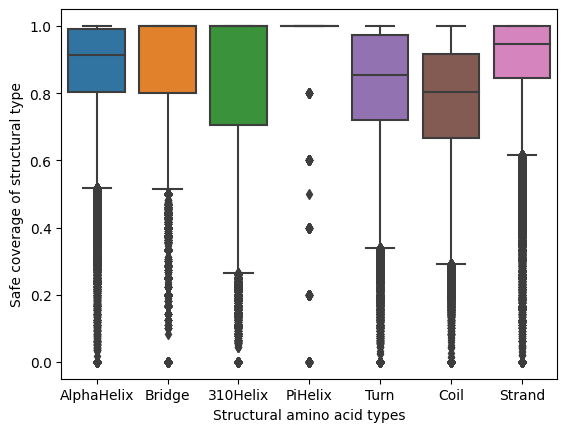

In [74]:
print(STRIDES)
boxplot_safe_per_stride(vals)

In [75]:
props_of_strides, number_of_strides = calc_proportion_of_strides(groups)
print(props_of_strides)

[0.4032007169256339, 0.008668168682476905, 0.032511195523336194, 7.727632066395815e-05, 0.17741182267498903, 0.19089827081353128, 0.18723254905936873]


In [58]:
props_of_strides_to_50, number_of_strides_to_50 = calc_proportion_of_strides(groups, id_range=[0, 50])
print(props_of_strides_to_50)

[0.40710058480946065, 0.1767881185778173, 0.18224294282164116, 0.1922270633279341, 0.00864373820437868, 0.032908970028821996, 8.858222994612949e-05]


In [ ]:
calc_window_lengths(groups, ['51', '75', '00'], [0,2,4,6,8,10,15], id_ranges=[[0,100], [0,20], [20,40], [40,70], [70,100]])

In [ ]:
calc_window_lengths(groups, ['75'], [8], id_ranges=[[0,100], [0,20], [20,40], [40,70], [70,100]])

Alpha: 75, Delta: 8
ID range: [0%, 100%]
Average window length: 40.73026724415108
Median window length: 17.0
Average sequence length: 321.8905890991189
Number of sequences: 400408
Number of safety windows: 2643650
Number of safety windows of range [0, 10]: 1797368
Number of safety windows of range [10, 20]: 362239
Number of safety windows of range [20, 30]: 165110
Number of safety windows of range [30, 40]: 87904
Number of safety windows of range [40, 50]: 57499
Number of safety windows of range [50, 100]: 179486
ID range: [0%, 20%]
Average window length: 14.705488389944348
Median window length: 9.0
Average sequence length: 467.74024640657086
Number of sequences: 2922
Number of safety windows: 52110
Number of safety windows of range [0, 10]: 48775
Number of safety windows of range [10, 20]: 2662
Number of safety windows of range [20, 30]: 512
Number of safety windows of range [30, 40]: 166
Number of safety windows of range [40, 50]: 24
Number of safety windows of range [50, 100]: 16
ID

In [ ]:
print_window_lengths(groups, alphas, deltas)

In [ ]:
groups = filter_clusters(groups, alphas, deltas)

In [ ]:
for a in alphas:
    for d in deltas:
        print(a,d)
        print("Number of sequences with no safe positions: {}".format(len(groups[(a,d)][groups[(a,d)].safe_coverage == 0])))
        print("Number of clusters: {}".format(len(groups[(a,d)]['ref'].unique())))
        print("Number of sequences with 0 recall: {}".format(len(groups[(a,d)][groups[(a,d)].recall == 0])))

In [ ]:
sb.set_theme(style="whitegrid", font_scale=2.5)
violinplot_several_idranges(groups, ['51', '75', '00'], [0, 2, 4, 6, 8, 10, 15], ["recall", "safe_coverage"], id_ranges=[[0,20], [20,40], [40,70], [70,100], [0,100]])

In [ ]:
sb.set_theme(style="whitegrid", font_scale=2.5)
violinplot_several_idranges(groups, ['75'], [8], ["recall", "safe_coverage"], id_ranges=[[0,20], [20,40], [40,70], [70,100], [0,100]], sc_range=[0, 0.8])

In [ ]:
sb.set_theme(style="whitegrid", font_scale=1)
violinplot(groups, alphas, deltas, ["precision"])

Precision and recall heatmap for different alpha and delta parameters, all identities (%).

In [ ]:
def grid_heatmap_id(groups, x, y, alpha, delta, id_range):
    fig, axes = plt.subplots(nrows=1, ncols=len(id_range), figsize=(7*len(id_range), 5))

    for i, (bot, top) in enumerate(id_range):
            df = groups[(alpha, delta)]

            df = df[(bot <= df.identity) & (df.identity <= top)]
            h = axes[i].hist2d(
                df[x].values, df[y].values,
                bins=(50,50), cmap=plt.cm.jet, range=np.array([(0,1),(0,1)]),
                density=True,
                norm=colors.Normalize()
            )
            fig.colorbar(h[3], ax=axes[i])

            axes[i].set_title(f"Identity Range: {bot}% - {top}%")
            axes[i].set_xlabel(x)
            if y == "safe_coverage":
                axes[i].set_ylabel("Safety Coverage")
            else:
                axes[i].set_ylabel(y)

    
    plt.savefig("heatmap_id_shift.pdf", bbox_inches = "tight")

    plt.show()

In [ ]:
grid_heatmap_id(groups, "F1-score", "safe_coverage", '75', 8, id_range=list([(0,20), (20, 40), (40,70), (70,100), (0,100)]))

In [ ]:
def recall_sc(groups, alphas, d, bins=21, id_ranges=[[0,100]], sc_ranges=[[0.0,1.0]]):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(6*2 + 4, 5))
    L = np.linspace(0, 1, bins)
    for (i,a) in enumerate(alphas):
        for (ir,id_range) in enumerate(id_ranges):
            for (sc, sc_range) in enumerate(sc_ranges):
                df = groups[(a, d)]
                if id_range != None:
                    df = df[(id_range[0] <= df.identity) & (df.identity <= id_range[1])]
                if sc_range != None:
                    df = df[(sc_range[0] <= df.safe_coverage) & (df.safe_coverage <= sc_range[1])]
                loss = df.FN / (df.TP + df.FN)
                recall = df.TP / (df.TP + df.FN)
                # ALL = sum(df.TP + df.FP + df.TN + df.FN) # old, bugged version
                Y = np.zeros(bins, dtype=float)
                for (k,x) in enumerate(L):
                    df_C = df[recall >= x]    # sequences with recall at least x
                    df_U = df[recall < x]     # sequences that cannot be compressed
                    ALL = sum(df_C.TP + df_C.FP + df_C.TN + df_C.FN) # new, fixed version
                    # Y[k] = ALL / (sum(df_C.TP + df_C.FP) + sum(df_U.TP+df_U.FP+df_U.TN+df_U.FN)) - 1.0
                    Y[k] = (sum(df_C.TP + df_C.FP)) / ALL # safety coverage
                axes[0].plot(L, Y, label=r"[" + str(id_range[0]) + ", " + str(id_range[1]) + "]", color=PALLETTE[ir], linestyle='solid')
        # axes.plot([0,1], [0,1], color="r", linewidth=0.5, label="y=x")
        
    Y = np.zeros(bins, dtype=float)
    for (i,a) in enumerate(alphas):
        for (ir, id_range) in enumerate(id_ranges):
            for (sc, sc_range) in enumerate(sc_ranges):
                for (k,x) in enumerate(L):
                    df = groups[(a,d)]
                    if id_range != None:
                        df = df[(id_range[0] <= df.identity) & (df.identity <= id_range[1])]
                    if sc_range != None:
                        df = df[(sc_range[0] <= df.safe_coverage) & (df.safe_coverage <= sc_range[1])]
                    recall = df.TP / (df.TP + df.FN)
                    ALL = len(df.id)
                    df_R = df[recall >= x]
                    RECALL = len(df_R.id)
                    Y[k] = RECALL / ALL
                axes[1].plot(L, Y, color=PALLETTE[ir], linestyle='solid')
        
    #axes[0].set_title(r" $\Delta$ " + str(d))
    axes[0].set_xlabel(f"Stable structure retention $\geq x$")
    axes[0].set_ylabel("Safety coverage")
    axes[0].legend()
    axes[0].set_ylim(0,1)
    axes[0].set_xlim(0.6, 1)
        
    #axes[1].set_title(r" $\Delta$ " + str(d))
    axes[1].set_xlabel(r"Stable structure retention $\geq x$")
    axes[1].set_ylabel("Proportion of sequences\nin the identity range")
    #axes[1].legend()
    axes[1].set_ylim(0,1)
    axes[1].set_xlim(0.6, 1)
    

    plt.savefig(f"recall_sc_{sc_ranges[0][0]}-{sc_ranges[0][1]}.pdf", bbox_inches="tight")
    print(f"recall_sc_{sc_ranges[0][0]}-{sc_ranges[0][1]}.pdf")
    plt.show()

In [ ]:
sb.set(style="whitegrid", font_scale=1.5)
recall_sc(groups, ['75'], 8, 51, id_ranges=[[0,20], [20,40], [40,70], [70,100], [0,100]])

In [ ]:
sb.set(style="whitegrid", font_scale=1.5)
recall_sc(groups, ['75'], 8, 51, id_ranges=[[0,20], [20,40], [40,70], [70,100], [0,100]], sc_ranges=[[0.0, 0.8]])